In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

import os
from src.plot_utils import plot_history

/home/javiermunoz/anaconda3/envs/tf/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [3]:
gpu_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from src.config import DATA_PATH, SPLITS
import pathlib

In [5]:
subset_size = 10
subset = f"subset_{subset_size}_lsa_64"

In [6]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

## 2. Loading Video Dataset

https://www.tensorflow.org/tutorials/load_data/video

In [7]:
from src.load_dataset_aux import frames_from_video_file, to_gif
from src.frame_generator import FrameGenerator
import tensorflow as tf

In [8]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 4


In [9]:
n_frames = 10
batch_size = 4

# We specify the shape of the output, such as, the Generator will produce a tuple of both
# videos, class, where the videos will have 3 channels, and the rest of dimensions will remain the same.
#   VideoShape -> (F, H, W, C)
output_signature = (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
                    tf.TensorSpec(shape=(), dtype=tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature=output_signature)
# Also, we batchify the data, so the training process is not as memory consuming as if the whole dataset was 
# loaded into memory.
# VideoShape -> (B, F, H, W, C)
# train_ds = train_ds.batch(batch_size)
train_ds = train_ds.batch(batch_size)

# We reproduce this process for the validation and test splits too.
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature=output_signature)

val_ds = val_ds.batch(batch_size)
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature=output_signature)

test_ds = test_ds.batch(batch_size)

In [10]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (4, 10, 224, 224, 3)
Shape of training labels: (4,)
Shape of validation set of frames: (4, 10, 224, 224, 3)
Shape of validation labels: (4,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

# 3. Model definition and Training

In [12]:
tf.keras.backend.clear_session()  

Input layer

In [13]:
# Construct the input layer with no definite frame size.
inputs = tf.keras.layers.Input(shape=(None, *train_frames.shape[2:]))
# Reescale the values of the pixels (per frame)
inputs_rescaled = tf.keras.layers.Rescaling(scale=255)(inputs)

Auxiliary branch

In [14]:
# We will construct 1 `ConvLSTM2D` layer with batch normalization,
x_aux = tf.keras.layers.ConvLSTM2D(filters=8,
                           kernel_size=(3, 3),
                           strides=(2,2),
                           stateful=False,
                           return_sequences=False,
                           activation="tanh")(inputs_rescaled)
x_aux = tf.keras.layers.BatchNormalization()(x_aux)
x_aux = tf.keras.layers.Dropout(0.2)(x_aux)
x_aux = tf.keras.layers.Conv2D(filters=16,
                                 kernel_size=(3,3),                       
                                 strides=(1,1))(x_aux)
x_aux = tf.keras.layers.BatchNormalization()(x_aux)
x_aux = tf.keras.layers.Dropout(0.2)(x_aux)
x_aux = tf.keras.layers.Conv2D(filters=8,
                                 kernel_size=(3,3),                       
                                 strides=(1,1))(x_aux)
x_aux = tf.keras.layers.BatchNormalization()(x_aux)
res_aux = tf.keras.layers.Dropout(0.2)(x_aux)

### Main Branch

In [15]:

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
x_main = tf.keras.layers.ConvLSTM2D(filters=8,
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    stateful=False,
                                    return_sequences=True,
                                    activation="tanh")(inputs_rescaled)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_main = tf.keras.layers.Dropout(0.2)(x_main)
x_main = tf.keras.layers.ConvLSTM2D(filters=8,
                                    kernel_size=(3, 3),
                                    strides=(1,1),
                                    stateful=False,
                                    return_sequences=True,
                                    activation="tanh")(x_main)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_main = tf.keras.layers.Dropout(0.2)(x_main)
x_main = tf.keras.layers.ConvLSTM2D(filters=16,
                                    kernel_size=(3, 3),
                                    strides=(2,2),
                                    stateful=False,
                                    return_sequences=False,
                                    activation="tanh")(x_main)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_main = tf.keras.layers.Dropout(0.2)(x_main)
x_main = tf.keras.layers.Conv2D(filters=8,
                               kernel_size=(3,3),                       
                               strides=(1,1))(x_main)
x_main = tf.keras.layers.BatchNormalization()(x_main)
x_add = tf.keras.layers.Add()([x_main, res_aux])
x_add = tf.keras.layers.Conv2D(filters=16,
                               kernel_size=(3, 3),                       
                               strides=(1,1))(x_add)

x_add = tf.keras.layers.GlobalMaxPooling2D()(x_add)
outputs = tf.keras.layers.Dense(units=10, activation='softmax')(x_add)

model = tf.keras.Model(inputs, outputs)

In [16]:
frames, label = next(iter(train_ds))
model.build(frames)

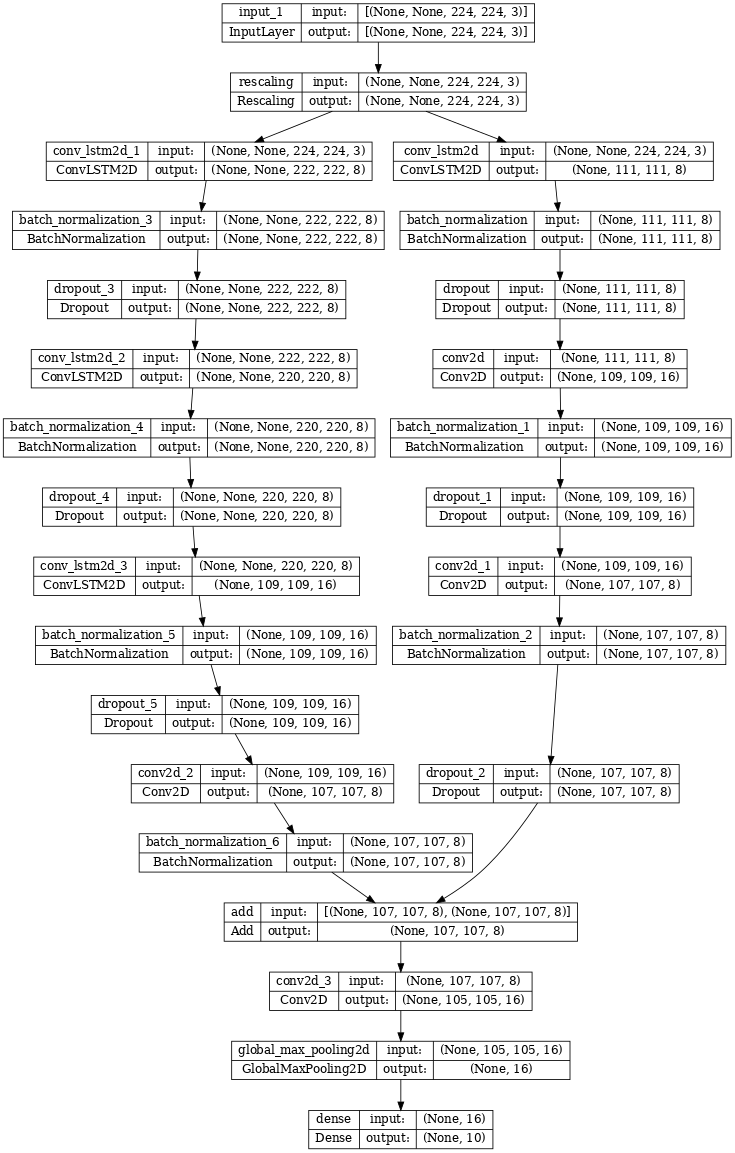

In [17]:
# Visualize the model
tf.keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [18]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-03),
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 224,   0           []                               
                                224, 3)]                                                          
                                                                                                  
 rescaling (Rescaling)          (None, None, 224, 2  0           ['input_1[0][0]']                
                                24, 3)                                                            
                                                                                                  
 conv_lstm2d_1 (ConvLSTM2D)     (None, None, 222, 2  3200        ['rescaling[0][0]']              
                                22, 8)                                                        

In [23]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

bst_model_path = "src/convlstm/bestmodels/best_stateless_weights.h5"

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

# Define some callbacks to improve training.
early_loss_stopping = EarlyStopping(monitor="loss", patience=15)
early_acc_stopping = EarlyStopping(monitor="accuracy", patience=15)
mod_ckpoint = ModelCheckpoint(filepath = bst_model_path, save_best_only=True, save_weights_only=True, monitor="val_accuracy")

callbacks=[
    #early_loss_stopping,
    #early_acc_stopping,
    mod_ckpoint,
    MyThresholdCallback(threshold=0.96)
]

In [24]:
# Define modifiable training hyperparameters.
epochs = 60

# Fit the model to the training data using a generator.
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[callbacks],
)

Epoch 1/60
99/99 [==============================] - 52s 526ms/step - loss: 0.2489 - accuracy: 0.9036 - val_loss: 0.5599 - val_accuracy: 0.8167
Epoch 2/60
99/99 [==============================] - 51s 515ms/step - loss: 0.2859 - accuracy: 0.8858 - val_loss: 0.4465 - val_accuracy: 0.8500
Epoch 3/60
99/99 [==============================] - 51s 517ms/step - loss: 0.2738 - accuracy: 0.8883 - val_loss: 0.2867 - val_accuracy: 0.9333
Epoch 4/60
99/99 [==============================] - 52s 526ms/step - loss: 0.1467 - accuracy: 0.9467 - val_loss: 0.2329 - val_accuracy: 0.9500
Epoch 5/60
99/99 [==============================] - 51s 514ms/step - loss: 0.1278 - accuracy: 0.9695 - val_loss: 0.3845 - val_accuracy: 0.8500


In [27]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
12/12 [==============================] - 12s 1s/step - loss: 0.1939 - accuracy: 0.8913
test loss, test acc: [0.19386644661426544, 0.8913043737411499]


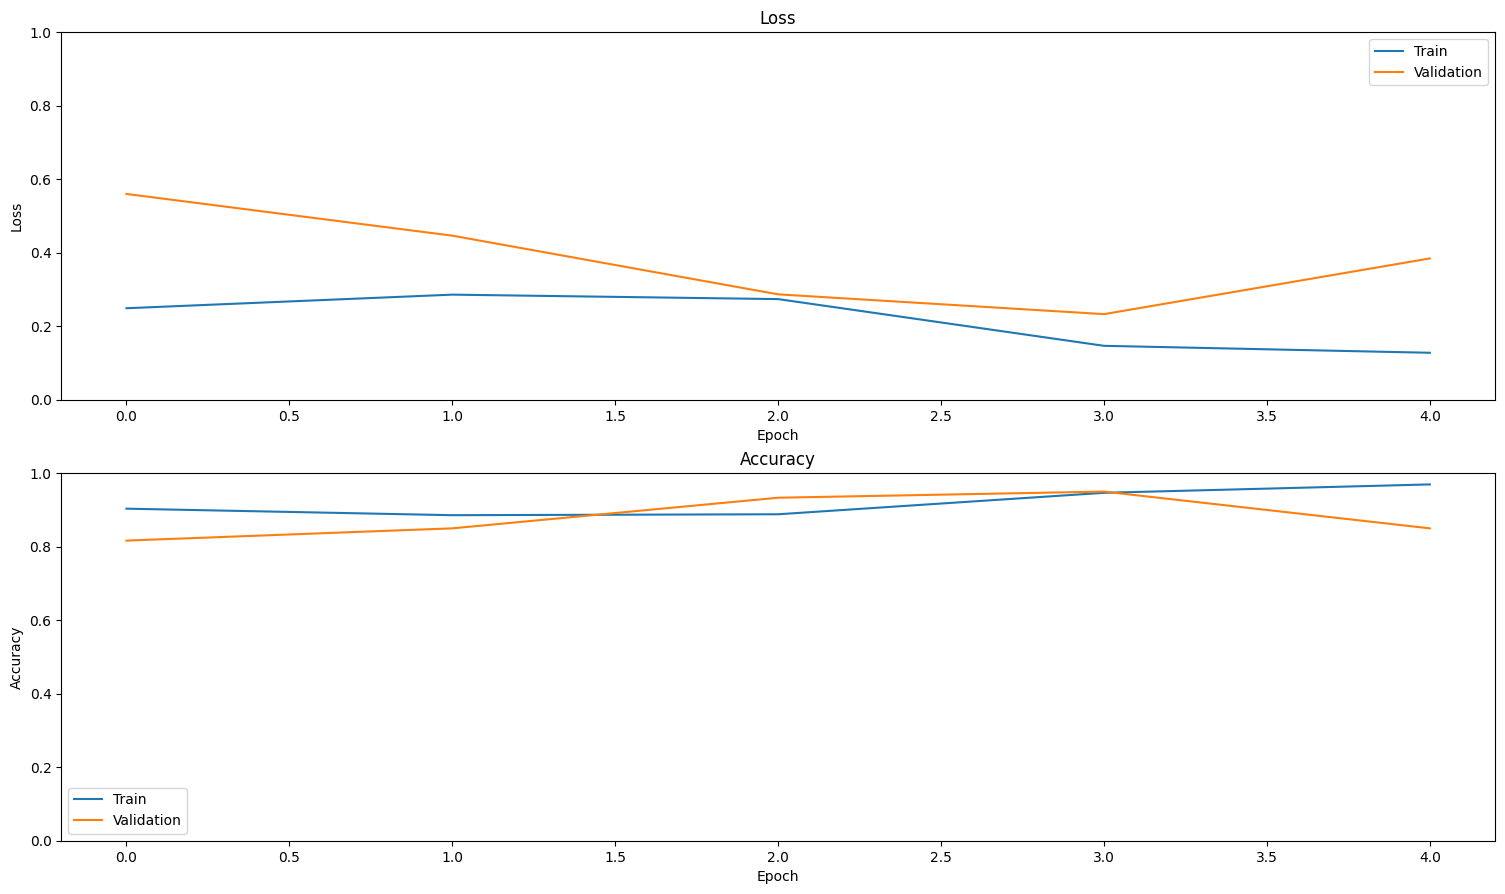

In [26]:
plot_history(history)